In [1]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
from scipy import optimize
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission
from src.smear import smear
from src.select_tof import select_tof_ptbc, select_tof_fimg
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq, tof_to_energy_dl

In [2]:
ArIn = h5py.File("temp_data/Ar.hdf5", "r")
ArOut = h5py.File("temp_data/bottle.hdf5", "r")
amp_ArIn = ArIn['amp'][:]
en_ArIn = ArIn['energy'][:]
tof_ArIn = ArIn['tof'][:]
norm_ArIn = ArIn['norm'][0]
detn_ArIn = ArIn['detn'][:]
amp_ArOut = ArOut['amp'][:]
en_ArOut = ArOut['energy'][:]
tof_ArOut = ArOut['tof'][:]
norm_ArOut = ArOut['norm'][0]
detn_ArOut = ArOut['detn'][:]

In [3]:
tof_ArIn_select = select_tof_ptbc(tof_ArIn, detn_ArIn, amp_ArIn)
tof_ArOut_select = select_tof_ptbc(tof_ArOut, detn_ArOut, amp_ArOut)

In [5]:
en_ArIn_select = tof_to_energy(tof_ArIn_select / 1e9, 182.3, 939.56542, 299792458) * 1e6
en_ArOut_select = tof_to_energy(tof_ArOut_select / 1e9, 182.3, 939.56542, 299792458) * 1e6

In [3]:
rf = uproot.open("data/RF.root")

In [4]:
rfnp = rf['histfluka;1'].to_numpy()

In [5]:
rfnp

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([1.00000000e-03, 1.02329299e-03, 1.04712855e-03, ...,
        9.54992586e+08, 9.77237221e+08, 1.00000000e+09]),
 array([-200., -199., -198., -197., -196., -195., -194., -193., -192.,
        -191., -190., -189., -188., -187., -186., -185., -184., -183.,
        -182., -181., -180., -179., -178., -177., -176., -175., -174.,
        -173., -172., -171., -170., -169., -168., -167., -166., -165.,
        -164., -163., -162., -161., -160., -159., -158., -157., -156.,
        -155., -154., -153., -152., -151., -150., -149., -148., -147.,
        -146., -145., -144., -143., -142., -141., -140., -139., -138.,
        -137., -136., -135., -134., -133., -132., -131., -130., -129.,
        -128., -127., -126., -125., -124., -123., -122., -121., 

In [70]:
tot = np.zeros(900)

In [72]:
for i in range(1200):
    tot += rfnp[0][i]

In [77]:
average = tot / 1200

In [78]:
mean_dl = np.average((rfnp[2][1:] + rfnp[2][:-1])/ 2, axis = 0, weights = average)/100

In [79]:
sig_dl = np.sqrt(np.cov((rfnp[2][1:] + rfnp[2][:-1])/ 2, aweights= average))/100

In [80]:
print(mean_dl, sig_dl)

0.45170832546978906 0.42282161598809076


In [63]:
dl_avg = []
dl_sig = []

In [85]:
for arr in rfnp[0]:
    s = sum(arr)
    if s == 0:
        dl_avg.append(0)
        dl_sig.append(0)
        continue
    dl_avg.append(np.average((rfnp[2][1:] + rfnp[2][:-1])/ 2, axis = 0, weights = arr)/100)
    dl_sig.append(np.sqrt(np.cov((rfnp[2][1:] + rfnp[2][:-1])/ 2, aweights= arr))/100)

In [89]:
f = h5py.File("data/rf_avg.h5py", "w")

In [90]:
f.create_dataset("dl_avg", data=dl_avg)
f.create_dataset("dl_sig", data=dl_sig)

<HDF5 dataset "dl_sig": shape (3598,), type "<f8">

In [91]:
f.close()

In [6]:
rfnp[1]

array([1.00000000e-03, 1.02329299e-03, 1.04712855e-03, ...,
       9.54992586e+08, 9.77237221e+08, 1.00000000e+09])

In [17]:
len(rfnp[1])

1201

In [18]:
len(rfnp[0])

1200

In [65]:
rfnp[1][1200]

1000000000.0

In [7]:
int((np.log10(np.array([1,1])) + 3) * 100)

TypeError: only size-1 arrays can be converted to Python scalars

In [15]:
en_ArIn_select_short = tof_to_energy(tof_ArIn_select / 1e9, 182.3 + mean_dl - sig_dl, 939.56542, 299792458) * 1e6
en_ArOut_select_short = tof_to_energy(tof_ArOut_select / 1e9, 182.3 + mean_dl - sig_dl, 939.56542, 299792458) * 1e6
en_ArIn_select_avg = tof_to_energy(tof_ArIn_select / 1e9, 182.3 + mean_dl, 939.56542, 299792458) * 1e6
en_ArOut_select_avg = tof_to_energy(tof_ArOut_select / 1e9, 182.3 + mean_dl, 939.56542, 299792458) * 1e6
en_ArIn_select_long = tof_to_energy(tof_ArIn_select / 1e9, 182.3 + mean_dl + sig_dl, 939.56542, 299792458) * 1e6
en_ArOut_select_long = tof_to_energy(tof_ArOut_select / 1e9, 182.3 + mean_dl + sig_dl, 939.56542, 299792458) * 1e6

In [6]:
en_ArIn_select_avg, en_ArIn_select_short, en_ArIn_select_long = tof_to_energy_dl(tof_ArIn_select / 1e9, 182.3, 939.56542, 299792458)
en_ArOut_select_avg, en_ArOut_select_short, en_ArOut_select_long = tof_to_energy_dl(tof_ArOut_select / 1e9, 182.3, 939.56542, 299792458)
en_ArIn_select_avg *= 1e6
en_ArIn_select_short *= 1e6
en_ArIn_select_long *= 1e6
en_ArOut_select_avg *= 1e6
en_ArOut_select_short *= 1e6
en_ArOut_select_long *= 1e6

In [7]:
logbins = np.logspace(-1, 9, 201)

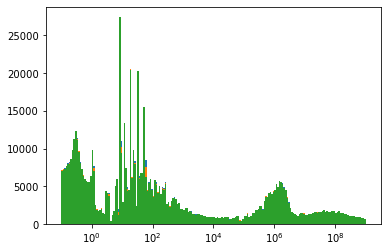

In [8]:
hist_ArIn_short, bins_ArIn_short, _ = plt.hist(en_ArIn_select_short, bins = logbins, range = (0, 1e9))
hist_ArIn_avg, bins_ArIn_avg, _ = plt.hist(en_ArIn_select_avg, bins = logbins, range = (0, 1e9))
hist_ArIn_long, bins_ArIn_long, _ = plt.hist(en_ArIn_select_long, bins = logbins, range = (0, 1e9))
plt.xscale('log')

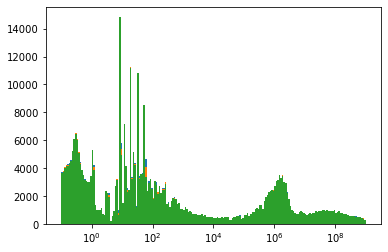

In [9]:
hist_ArOut_short, bins_ArOut_short, _ = plt.hist(en_ArOut_select_short, bins = logbins, range = (0, 1e9))
hist_ArOut_avg, bins_ArOut_avg, _ = plt.hist(en_ArOut_select_avg, bins = logbins, range = (0, 1e9))
hist_ArOut_long, bins_ArOut_long, _ = plt.hist(en_ArOut_select_long, bins = logbins, range = (0, 1e9))
plt.xscale('log')

In [10]:
error_ArIn_short = np.sqrt(hist_ArIn_short)
error_ArIn_avg = np.sqrt(hist_ArIn_avg)
error_ArIn_long = np.sqrt(hist_ArIn_long)
error_ArOut_short = np.sqrt(hist_ArOut_short)
error_ArOut_avg = np.sqrt(hist_ArOut_avg)
error_ArOut_long = np.sqrt(hist_ArOut_long)
x_en = (bins_ArIn_avg[1:] + bins_ArIn_avg[:-1]) / 2

In [11]:
tr_short, tr_error_short = transmission(hist_ArIn_short / norm_ArIn, error_ArIn_short / norm_ArIn, hist_ArOut_short / norm_ArOut, np.sqrt(hist_ArOut_short) / norm_ArOut)
tr_avg, tr_error_avg = transmission(hist_ArIn_avg / norm_ArIn, error_ArIn_avg / norm_ArIn, hist_ArOut_avg / norm_ArOut, np.sqrt(hist_ArOut_avg) / norm_ArOut)
tr_long, tr_error_long = transmission(hist_ArIn_long / norm_ArIn, error_ArIn_long / norm_ArIn, hist_ArOut_long / norm_ArOut, np.sqrt(hist_ArOut_long) / norm_ArOut)

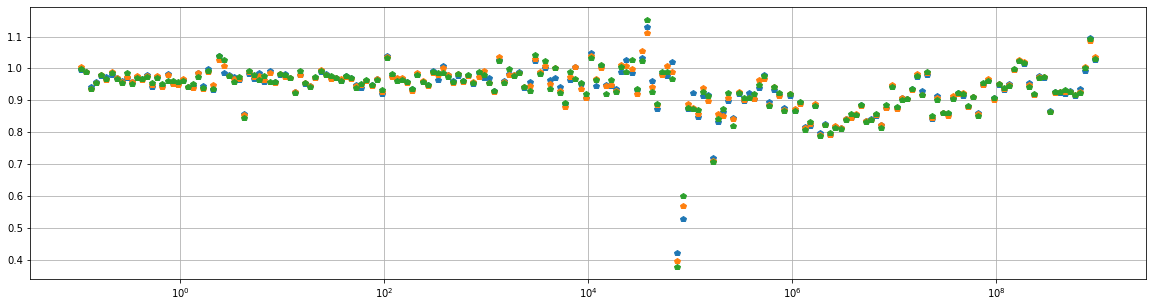

In [12]:
plt.figure(figsize=(20,5))
plt.errorbar(x_en, tr_short, fmt="p")
plt.errorbar(x_en, tr_avg, fmt="p")
plt.errorbar(x_en, tr_long, fmt="p")
plt.xscale('log')
plt.grid()

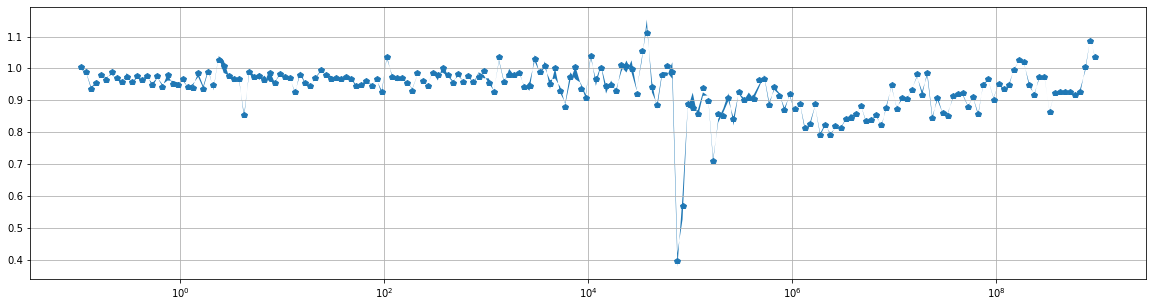

In [13]:
plt.figure(figsize=(20,5))
plt.errorbar(x_en, tr_avg, fmt="p")
plt.fill_between(x_en, tr_short, tr_long)
plt.xscale('log')
plt.grid()

In [14]:
tr_error_sys_up = abs(tr_long - tr_avg)
tr_error_sys_down = abs(tr_avg - tr_short)

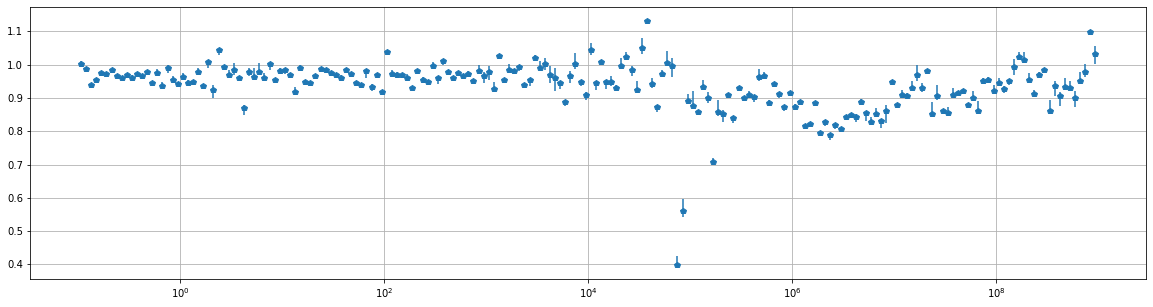

In [24]:
plt.figure(figsize=(20,5))
plt.errorbar(x_en, tr_avg, yerr=[tr_error_sys_down,tr_error_sys_up], fmt="p")
plt.xscale('log')
plt.grid()

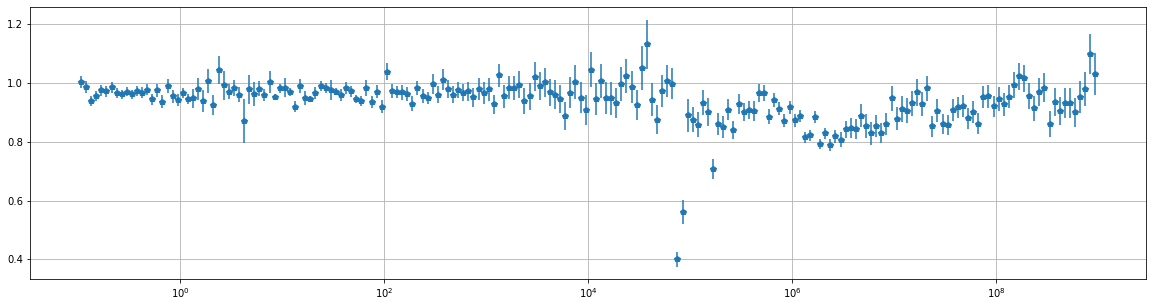

In [25]:
plt.figure(figsize=(20,5))
plt.errorbar(x_en, tr_avg, yerr=tr_error_avg, fmt="p")
plt.xscale('log')
plt.grid()

In [156]:
f = open("endf/Al.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[16:27]))
energy = np.array(energy) * 1e6
crs = np.array(crs)

In [27]:
rfnp[1][670]

5011.872336272725

In [28]:
rfnp[1][685]

7079.457843841388

In [29]:
tot = np.zeros(900)

In [30]:
for i in range(670, 686):
    tot += rfnp[0][i]

In [31]:
average = tot / 15

In [32]:
mean_dl = np.average((rfnp[2][1:] + rfnp[2][:-1])/ 2, axis = 0, weights = average)/100

In [33]:
sig_dl = np.sqrt(np.cov((rfnp[2][1:] + rfnp[2][:-1])/ 2, aweights= average))/100

In [34]:
print(mean_dl, sig_dl)

0.2914282056211275 0.36507441111770844


In [157]:
tof = energy_to_tof(energy/1e6, 182.3, 939.56542, 299792458) * 1e9
ts = xsec_to_ts(crs * 1e-28, 2710, 0.05, 4.48e-26)

In [158]:
tof = tof[::-1]
ts = ts[::-1]

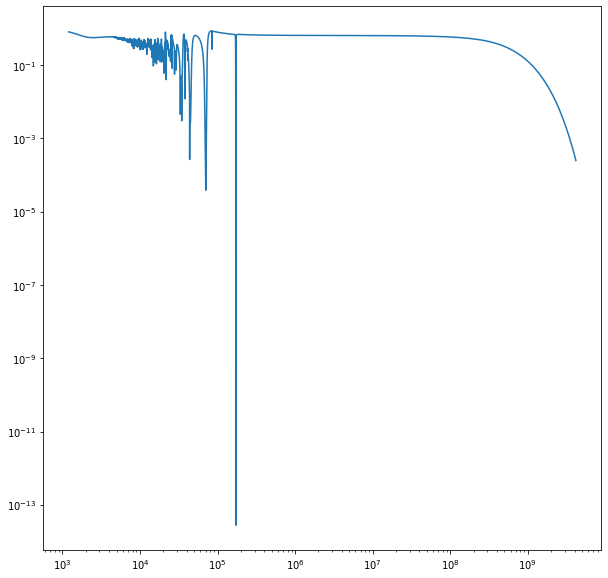

In [159]:
plt.figure(figsize=(10,10))
plt.plot(tof, ts)
plt.xscale('log')
plt.yscale('log')

In [38]:
left = search_asc(tof, 68000)
right = search_asc(tof, 72000)

In [39]:
left

8728

In [40]:
right

8779

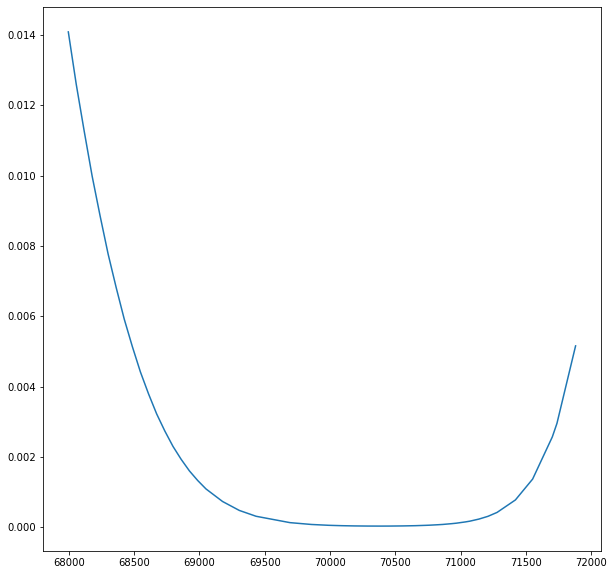

In [41]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [42]:
cur_ts = ts[left]
while(cur_ts > 0.0001):
    left += 1
    cur_ts = ts[left]

In [43]:
left

8750

In [44]:
cur_ts = ts[right]
while(cur_ts > 0.0001):
    right -= 1
    cur_ts = ts[right]

In [45]:
right

8766

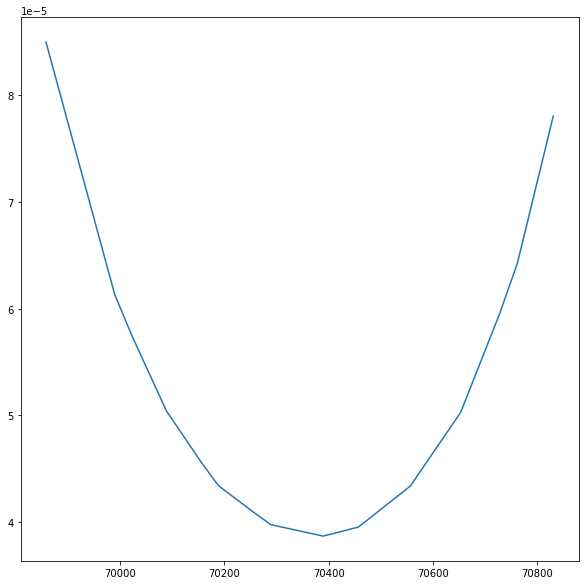

In [46]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [47]:
tof[left]

69857.55983054312

In [48]:
tof[right]

70865.09258836188

In [49]:
tof[right] - tof[left]

1007.5327578187571

In [91]:
import math

In [92]:
def poisson(k, mu):
    return mu**k * np.exp(-mu) / math.factorial(k)

In [93]:
0.3173/2

0.15865

In [103]:
def upper_sum(mu):
    return poisson(0, mu) + poisson(1, mu)

In [106]:
for i in np.linspace(3,3.5,51):
    print(str(i) + " " + str(upper_sum(i)))
#3.3 0.15859761982533205

3.0 0.19914827347145578
3.01 0.1976596318294533
3.02 0.1961808978152921
3.03 0.19471202164805318
3.04 0.1932529535565614
3.05 0.19180364378412074
3.06 0.19036404259315326
3.07 0.18893410026974528
3.08 0.18751376712810036
3.09 0.18610299351490223
3.1 0.18470172981358698
3.11 0.18330992644852834
3.12 0.1819275338891346
3.13 0.1805545026538614
3.14 0.17919078331413882
3.15 0.17783632649821676
3.16 0.17649108289492738
3.17 0.17515500325736794
3.18 0.17382803840650382
3.19 0.17251013923469383
3.2 0.1712012567091381
3.21 0.16990134187525113
3.22 0.16861034585995946
3.23 0.1673282198749266
3.24 0.16605491521970517
3.25 0.16479038328481854
3.26 0.16353457555477185
3.27 0.16228744361099431
3.2800000000000002 0.16104893913471413
3.29 0.15981901390976583
3.3 0.15859761982533205
3.31 0.15738470887862113
3.32 0.15618023317748056
3.33 0.15498414494294743
3.34 0.1537963965117381
3.35 0.15261694033867584
3.36 0.15144572899906014
3.37 0.15028271519097575
3.38 0.14912785173754511
3.39 0.1479810915891228

In [108]:
def lower_sum(mu):
    return 1 - poisson(0, mu)

In [112]:
for i in np.linspace(0.1,0.2,101):
    print(str(i) + " " + str(lower_sum(i)))
#0.173 0.15886238515537676

0.1 0.09516258196404048
0.101 0.09606696711413587
0.10200000000000001 0.09697044833112323
0.10300000000000001 0.09787302651848351
0.10400000000000001 0.09877470257879528
0.10500000000000001 0.09967547741373439
0.10600000000000001 0.10057535192407596
0.10700000000000001 0.1014743270096945
0.10800000000000001 0.10237240356956512
0.10900000000000001 0.10326958250176455
0.11 0.10416586470347178
0.111 0.10506125107096898
0.112 0.10595574249964279
0.113 0.10684933988398448
0.114 0.1077420441175917
0.115 0.10863385609316867
0.116 0.10952477670252736
0.117 0.11041480683658866
0.11800000000000001 0.11130394738538263
0.11900000000000001 0.1121921992380499
0.12000000000000001 0.11307956328284252
0.12100000000000001 0.11396604040712444
0.122 0.11485163149737287
0.123 0.1157363374391791
0.124 0.1166201591172491
0.125 0.11750309741540454
0.126 0.11838515321658394
0.127 0.11926632740284304
0.128 0.12014662085535621
0.129 0.12102603445441684
0.13 0.1219045690794387
0.131 0.12278222560895646
0.132 0.12

In [113]:
def upper_sum(mu):
    return poisson(0, mu)

In [123]:
for i in np.linspace(1.5,2,51):
    print(str(i) + " " + str(upper_sum(i)))
#1.84 0.15881742610692068

1.5 0.22313016014842982
1.51 0.2209099779593782
1.52 0.21871188695221475
1.53 0.21653566731600707
1.54 0.21438110142697794
1.55 0.21224797382674304
1.56 0.21013607120076472
1.57 0.20804518235702046
1.58 0.20597509820488344
1.59 0.20392561173421342
1.6 0.20189651799465538
1.61 0.1998876140751445
1.62 0.19789869908361465
1.63 0.19592957412690937
1.6400000000000001 0.19398004229089189
1.65 0.19204990862075413
1.66 0.19013898010152055
1.67 0.1882470656387468
1.68 0.18637397603940997
1.69 0.18451952399298926
1.7 0.18268352405273466
1.71 0.1808657926171221
1.72 0.17906614791149322
1.73 0.17728440996987782
1.74 0.17552040061699686
1.75 0.17377394345044514
1.76 0.17204486382305054
1.77 0.17033298882540943
1.78 0.1686381472685955
1.79 0.1669601696670407
1.8 0.16529888822158653
1.81 0.16365413680270405
1.82 0.16202575093388075
1.83 0.16041356777517274
1.84 0.15881742610692068
1.85 0.1572371663136276
1.8599999999999999 0.15567263036799733
1.87 0.1541236618151314
1.88 0.1525901057568839
1.89000000

In [50]:
Al_C = h5py.File("temp_data/Al5_C.hdf5", "r")

In [51]:
amp_Al_CIn = Al_C['amp'][:]
en_Al_CIn = Al_C['energy'][:]
tof_Al_CIn = Al_C['tof'][:]
norm_Al_CIn = Al_C['norm'][0]
detn_Al_CIn = Al_C['detn'][:]

In [52]:
Al_noC = h5py.File("temp_data/Al5_noC.hdf5", "r")

In [53]:
amp_Al_noCIn = Al_noC['amp'][:]
en_Al_noCIn = Al_noC['energy'][:]
tof_Al_noCIn = Al_noC['tof'][:]
norm_Al_noCIn = Al_noC['norm'][0]
detn_Al_noCIn = Al_noC['detn'][:]

In [54]:
tof_Al_CIn_select = tof_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]
detn_Al_CIn_select = detn_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]
amp_Al_CIn_select = amp_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]

In [55]:
tof_Al_CIn_select_2 = select_tof_ptbc(tof_Al_CIn_select, detn_Al_CIn_select, amp_Al_CIn_select)

In [56]:
tof_Al_CIn_select_2

array([70143.96276659])

In [57]:
tof_Al_noCIn_select = tof_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]
detn_Al_noCIn_select = detn_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]
amp_Al_noCIn_select = amp_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]

In [58]:
tof_Al_noCIn_select_2 = select_tof_ptbc(tof_Al_noCIn_select, detn_Al_noCIn_select, amp_Al_noCIn_select)

In [59]:
tof_Al_noCIn_select_2

array([], dtype=float64)

In [60]:
norm_Al_CIn

1.3550842338607104e+17

In [61]:
norm_Al_noCIn

1.2420786057694413e+17

In [62]:
1 / norm_Al_CIn / 1007.5327578187571

7.324441799181853e-21

In [124]:
3.3 / norm_Al_CIn / 1007.5327578187571

2.417065793730011e-20

In [125]:
0.173 / norm_Al_CIn / 1007.5327578187571

1.2671284312584603e-21

In [63]:
ArIn = h5py.File("temp_data/Ar.hdf5", "r")
ArOut = h5py.File("temp_data/bottle.hdf5", "r")
amp_ArIn = ArIn['amp'][:]
en_ArIn = ArIn['energy'][:]
tof_ArIn = ArIn['tof'][:]
norm_ArIn = ArIn['norm'][0]
detn_ArIn = ArIn['detn'][:]
amp_ArOut = ArOut['amp'][:]
en_ArOut = ArOut['energy'][:]
tof_ArOut = ArOut['tof'][:]
norm_ArOut = ArOut['norm'][0]
detn_ArOut = ArOut['detn'][:]

In [64]:
tof_ArIn_select = select_tof_ptbc(tof_ArIn, detn_ArIn, amp_ArIn)
tof_ArOut_select = select_tof_ptbc(tof_ArOut, detn_ArOut, amp_ArOut)

In [126]:
bg_ArIn_low = 1.2671284312584603e-21 * norm_ArIn * 1e9
bg_ArIn_mid = 7.324441799181853e-21 * norm_ArIn * 1e9
bg_ArIn_high = 2.417065793730011e-20 * norm_ArIn * 1e9

In [127]:
bg_ArOut_low = 1.2671284312584603e-21 * norm_ArOut * 1e9
bg_ArOut_mid = 7.324441799181853e-21 * norm_ArOut * 1e9
bg_ArOut_high = 2.417065793730011e-20 * norm_ArOut * 1e9

In [128]:
bg_ArIn_low_100 = bg_ArIn_low * 10
bg_ArIn_mid_100 = bg_ArIn_mid * 10
bg_ArIn_high_100= bg_ArIn_high * 10
bg_ArOut_low_100 = bg_ArOut_low * 10
bg_ArOut_mid_100 = bg_ArOut_mid * 10
bg_ArOut_high_100 = bg_ArOut_high * 10

In [129]:
bg_ArIn_low_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArIn_low_100))
bg_ArIn_mid_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArIn_mid_100))
bg_ArIn_high_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArIn_high_100))

In [130]:
bg_ArOut_low_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArOut_low_100))
bg_ArOut_mid_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArOut_mid_100))
bg_ArOut_high_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArOut_high_100))

In [131]:
norm_ArIn_low = norm_ArIn - bg_ArIn_low
norm_ArIn_mid = norm_ArIn - bg_ArIn_mid
norm_ArIn_high = norm_ArIn - bg_ArIn_high
norm_ArOut_low = norm_ArOut - bg_ArOut_low
norm_ArOut_mid = norm_ArOut - bg_ArOut_mid
norm_ArOut_high = norm_ArOut - bg_ArOut_high

In [132]:
en_ArIn_select = tof_to_energy(tof_ArIn_select / 1e9, 182.3, 939.56542, 299792458) * 1e6
en_ArOut_select = tof_to_energy(tof_ArOut_select / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArIn_low_en_100 = tof_to_energy(bg_ArIn_low_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArIn_mid_en_100 = tof_to_energy(bg_ArIn_mid_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArIn_high_en_100 = tof_to_energy(bg_ArIn_high_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArOut_low_en_100 = tof_to_energy(bg_ArOut_low_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArOut_mid_en_100 = tof_to_energy(bg_ArOut_mid_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArOut_high_en_100 = tof_to_energy(bg_ArOut_high_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6

/Users/livingroom-pc/Documents/artie/MArEX_Analysis/utils.py:32: RuntimeWarning: invalid value encountered in sqrt
  return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)


In [133]:
logbins = np.logspace(-1, 9, 201)

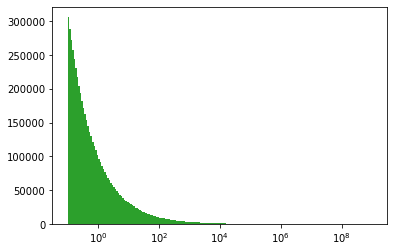

In [135]:
hist_ArIn_low_bg_100, _, _ = plt.hist(bg_ArIn_low_en_100, bins = logbins, range = (0, 1e9))
hist_ArIn_mid_bg_100, _, _ = plt.hist(bg_ArIn_mid_en_100, bins = logbins, range = (0, 1e9))
hist_ArIn_high_bg_100, _, _ = plt.hist(bg_ArIn_high_en_100, bins = logbins, range = (0, 1e9))
plt.xscale('log')

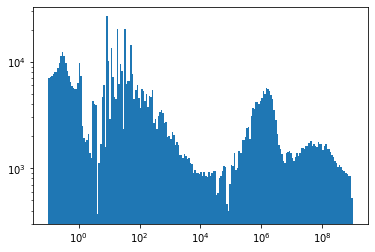

In [136]:
hist_ArIn, bins_ArIn, _ = plt.hist(en_ArIn_select, bins = logbins, range = (0, 1e9))
#hist_ArIn_high_bg , _, _= plt.hist(bg_ArIn_high_en, bins = logbins, range = (0, 1e9))
plt.xscale('log')
plt.yscale('log')

In [137]:
err_ArIn = np.sqrt(hist_ArIn)
#err_ArOut = np.sqrt(hist_ArOut)
x_en = (bins_ArIn[1:] + bins_ArIn[:-1]) / 2

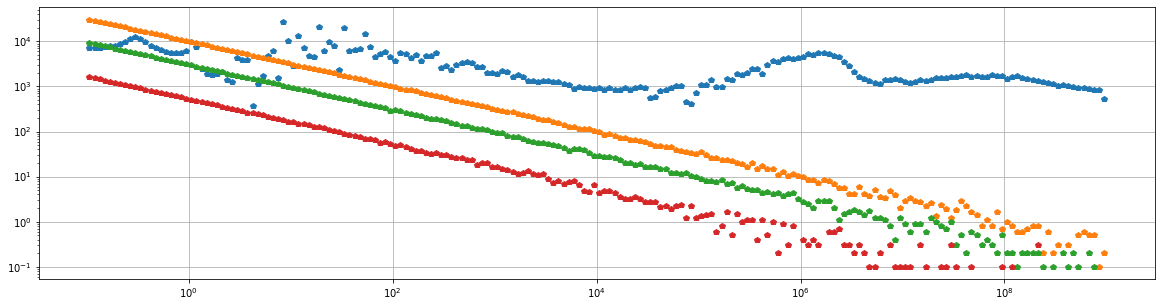

In [138]:
plt.figure(figsize=(20,5))
plt.errorbar(x_en, hist_ArIn, yerr=err_ArIn, fmt="p")
plt.errorbar(x_en, hist_ArIn_high_bg_100/10, fmt="p")
plt.errorbar(x_en, hist_ArIn_mid_bg_100/10, fmt="p")
plt.errorbar(x_en, hist_ArIn_low_bg_100/10, fmt="p")
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [139]:
1.84 / norm_Al_CIn / 1007.5327578187571

1.347697291049461e-20

In [140]:
bg_ArIn_high = 1.347697291049461e-20 * norm_ArIn * 1e9
bg_ArOut_high = 1.347697291049461e-20 * norm_ArOut * 1e9
bg_ArIn_high_100 = bg_ArIn_high * 10
bg_ArOut_high_100 = bg_ArOut_high * 10

In [141]:
bg_ArIn_high_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArIn_high_100))
bg_ArOut_high_arr_100 = np.random.uniform(1e-1, 1e9, int(bg_ArOut_high_100))
norm_ArIn_high = norm_ArIn - bg_ArIn_high
norm_ArOut_high = norm_ArOut - bg_ArOut_high

In [142]:
en_ArIn_select = tof_to_energy(tof_ArIn_select / 1e9, 182.3, 939.56542, 299792458) * 1e6
en_ArOut_select = tof_to_energy(tof_ArOut_select / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArIn_high_en_100 = tof_to_energy(bg_ArIn_high_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6
bg_ArOut_high_en_100 = tof_to_energy(bg_ArOut_high_arr_100 / 1e9, 182.3, 939.56542, 299792458) * 1e6

/Users/livingroom-pc/Documents/artie/MArEX_Analysis/utils.py:32: RuntimeWarning: invalid value encountered in sqrt
  return m * (1 / np.sqrt(1 - x * x / c / c / tof / tof) - 1)


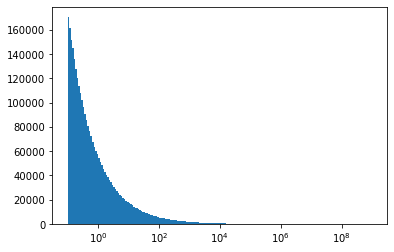

In [143]:
hist_ArIn_high_bg_100, _, _ = plt.hist(bg_ArIn_high_en_100, bins = logbins, range = (0, 1e9))
plt.xscale('log')

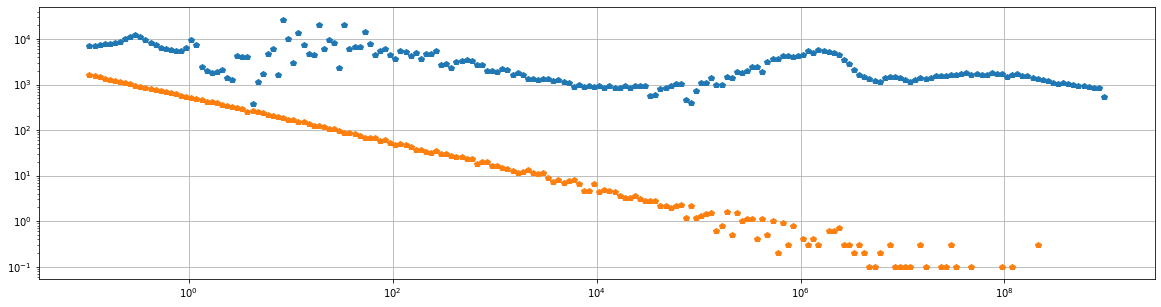

In [144]:
plt.figure(figsize=(20,5))
plt.errorbar(x_en, hist_ArIn, yerr=err_ArIn, fmt="p")
plt.errorbar(x_en, hist_ArIn_low_bg_100/10, fmt="p")
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [145]:
left = search_asc(tof, 150000)
right = search_asc(tof, 180000)

In [146]:
cur_ts = ts[left]
while(cur_ts > 0.0001):
    left += 1
    cur_ts = ts[left]

In [147]:
cur_ts = ts[right]
while(cur_ts > 0.0001):
    right -= 1
    cur_ts = ts[right]

In [148]:
tof[right] - tof[left]

445.4325822358951

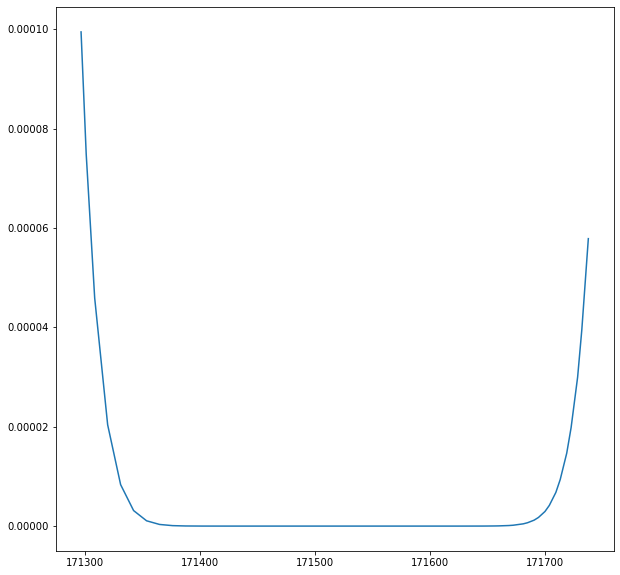

In [149]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [150]:
tof_Al_CIn_select = tof_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]
detn_Al_CIn_select = detn_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]
amp_Al_CIn_select = amp_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]

In [151]:
tof_Al_CIn_select_2 = select_tof_ptbc(tof_Al_CIn_select, detn_Al_CIn_select, amp_Al_CIn_select)

In [152]:
tof_Al_CIn_select_2

array([171636.25312095, 171426.54360622])

In [153]:
tof_Al_noCIn_select = tof_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]
detn_Al_noCIn_select = detn_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]
amp_Al_noCIn_select = amp_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]

In [154]:
tof_Al_noCIn_select_2 = select_tof_ptbc(tof_Al_noCIn_select, detn_Al_noCIn_select, amp_Al_noCIn_select)

In [155]:
tof_Al_noCIn_select_2

array([171449.54794284])

In [175]:
left = search_asc(tof, 68000)
right = search_asc(tof, 73000)

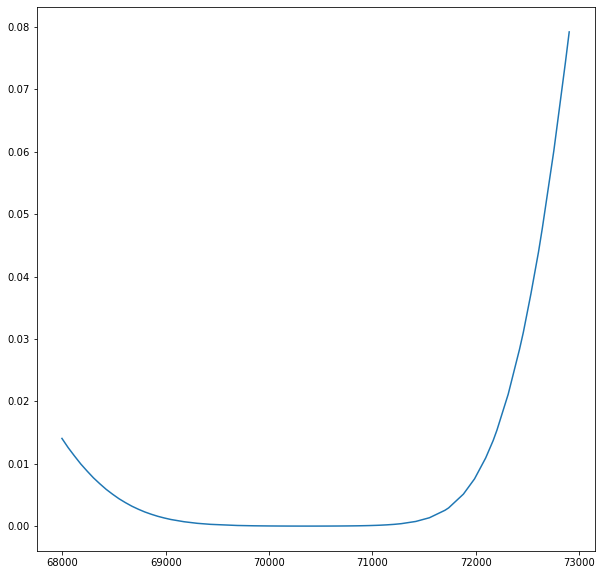

In [176]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [187]:
cur_ts = ts[left]
while(cur_ts > 0.001):
    left += 1
    cur_ts = ts[left]

In [188]:
cur_ts = ts[right]
while(cur_ts > 0.001):
    right -= 1
    cur_ts = ts[right]

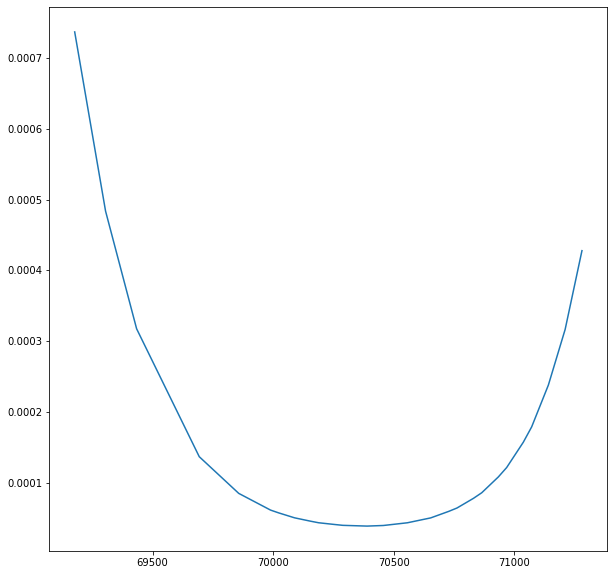

In [189]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [190]:
tof[right] - tof[left]

2243.2472800676915

In [191]:
tof_Al_CIn_select = tof_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]
detn_Al_CIn_select = detn_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]
amp_Al_CIn_select = amp_Al_CIn[(tof_Al_CIn >= tof[left]) & (tof_Al_CIn <= tof[right])]

In [192]:
tof_Al_CIn_select_2 = select_tof_ptbc(tof_Al_CIn_select, detn_Al_CIn_select, amp_Al_CIn_select)

In [193]:
tof_Al_CIn_select_2

array([70143.96276659])

In [194]:
tof_Al_noCIn_select = tof_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]
detn_Al_noCIn_select = detn_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]
amp_Al_noCIn_select = amp_Al_noCIn[(tof_Al_noCIn >= tof[left]) & (tof_Al_noCIn <= tof[right])]

In [195]:
tof_Al_noCIn_select_2 = select_tof_ptbc(tof_Al_noCIn_select, detn_Al_noCIn_select, amp_Al_noCIn_select)

In [196]:
tof_Al_noCIn_select_2

array([], dtype=float64)